## Построение дерева решений для прогноза сердечно-сосудистых заболеваний

Импортируем необходимые нам библиотеки.

In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

Загружаем данные.

In [2]:
df = pd.read_csv('mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [3]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.shape

(70000, 12)

In [5]:
df['age'] = df['age'] //365 

In [6]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
chol = pd.get_dummies(df['cholesterol'], prefix='cholesterol')
gluc = pd.get_dummies(df['gluc'], prefix='gluc')
data = pd.concat([df, chol, gluc], axis=1)

In [8]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,1,0,0
2,51,1,165,64.0,130,70,3,1,0,0,0,1,0,0,1,1,0,0
3,48,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,1,0,0


In [9]:
data.keys()

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'cholesterol_1',
       'cholesterol_2', 'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3'],
      dtype='object')

Делим на тренировочную и тестовую выборку.

In [11]:
x = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol','gluc', 'smoke', 'alco', 'active', 
     'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3']

X_train, X_valid, y_train, y_valid = train_test_split(data[x], data['cardio'], random_state = 17, test_size = 0.3)

In [14]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

tree_fit = tree.fit(X_train, y_train)

print('Score: ', tree_fit.score(X_train, y_train))

Score:  0.727714285714


In [17]:
export_graphviz(tree, feature_names=x, out_file='tree1.dot')
#Пользуйся http://www.webgraphviz.com

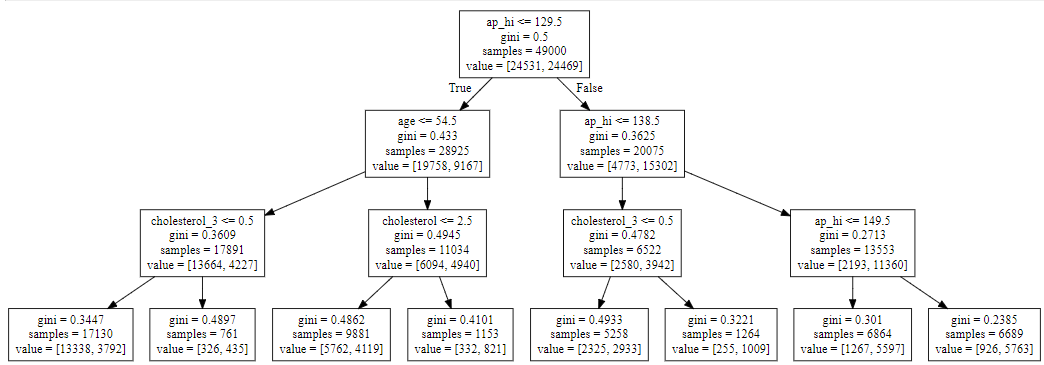

In [16]:
from PIL import Image
img = Image.open('tree1.png')
img

C помощью обученного дерева сделаем прогноз для отложенной выборки (X_valid, y_valid). Посчитаем долю верных ответов (accuracy).

In [15]:
y_pred = tree_fit.predict(X_valid)
print('accuracy_score: ', accuracy_score(y_valid, y_pred))

accuracy_score:  0.721285714286


In [16]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

In [17]:
%%time
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.1s finished


Wall time: 26.8 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [20]:
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

Best params: {'max_depth': 6}
Best cross validaton score 0.732142857143


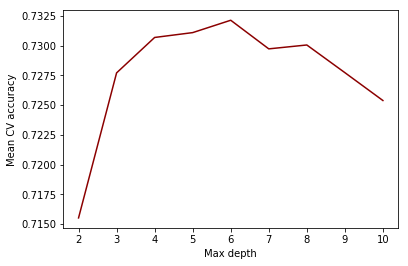

In [26]:
plt.plot(tree_params['max_depth'], 
         tree_grid.cv_results_['mean_test_score'], color='darkred')
plt.xlabel('Max depth')
plt.ylabel('Mean CV accuracy');

In [27]:
tree = DecisionTreeClassifier(max_depth=6, random_state=17)

tree_fit = tree.fit(X_train, y_train)

print('Score: ', tree_fit.score(X_train, y_train))

Score:  0.735530612245


In [28]:
y_pred = tree_fit.predict(X_valid)
print('accuracy_score: ', accuracy_score(y_valid, y_pred))

accuracy_score:  0.72580952381


### Случайный лес sklearn, подбор гиперпараметров

In [29]:
max_depth_values = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
max_features_values = [4, 5, 6, 7]
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [34]:
rf = RandomForestClassifier(random_state=17) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
random_grid = GridSearchCV(rf, forest_params, cv=skf, scoring = 'roc_auc')

In [35]:
random_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [37]:
print("Best params:", random_grid.best_params_)
print("Best cross validaton score", random_grid.best_score_)

Best params: {'max_depth': 9, 'max_features': 7}
Best cross validaton score 0.800743282583
